<img src='../img/bimbo.png'>

- Task: Demand = Sales - Returns
- Create holdout test set

## Data exploration

In [1]:
import pandas as pd
import numpy as np
import os
dir_sub = "C:/Users/568377/Cognizant/Data Science/kaggle/Bimbo Bread/submissions/"
dir_raw = "C:/Users/568377/Cognizant/Data Science/kaggle/Bimbo Bread/raw/"

In [153]:
subm = pd.read_csv(os.path.join(dir_raw,"sample_submission.csv"))
prod = pd.read_csv(os.path.join(dir_raw,"producto_tabla.csv"))
town_state = pd.read_csv(os.path.join(dir_raw,"town_state.csv"))
client = pd.read_csv(os.path.join(dir_raw,"cliente_tabla.csv"))

In [3]:
test = pd.read_csv(os.path.join(dir_raw,"test.csv"), nrows=500000)
train = pd.read_csv(os.path.join(dir_raw,"train.csv"), nrows=500000)

### Features

#### Product

In [154]:
prod.head()

,Producto_ID,NombreProducto
0,0,NO IDENTIFICADO 0
1,9,Capuccino Moka 750g NES 9
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41
3,53,Burritos Sincro 170g CU LON 53
4,72,Div Tira Mini Doradita 4p 45g TR 72


In [155]:
prod['unit_g'] = prod['NombreProducto'].str.extract("([0-9]+)(g )", expand=True)[1]
prod['amount_g'] = prod['NombreProducto'].str.extract("([0-9]+)(g )", expand=True)[0]
prod['unit_ml'] = prod['NombreProducto'].str.extract("([0-9]+)(ml )", expand=True)[1]
prod['amount_ml'] = prod['NombreProducto'].str.extract("([0-9]+)(ml )", expand=True)[0]

In [156]:
prod['amount_g'] = prod['amount_g'].convert_objects(convert_numeric=True)
prod['amount_ml'] = prod['amount_ml'].convert_objects(convert_numeric=True)

c:\users\568377\appdata\local\programs\python\python35-32\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':
c:\users\568377\appdata\local\programs\python\python35-32\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [157]:
prod.head()

,Producto_ID,NombreProducto,unit_g,amount_g,unit_ml,amount_ml
0,0,NO IDENTIFICADO 0,NaN,NaN,NaN,NaN
1,9,Capuccino Moka 750g NES 9,g,750.0,NaN,NaN
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,g,480.0,NaN,NaN
3,53,Burritos Sincro 170g CU LON 53,g,170.0,NaN,NaN
4,72,Div Tira Mini Doradita 4p 45g TR 72,g,45.0,NaN,NaN


In [162]:
%matplotlib inline

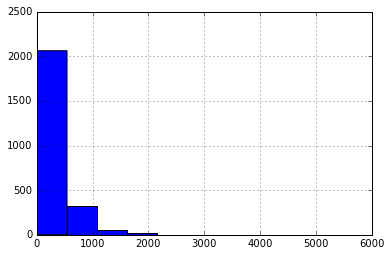

In [163]:
prod['amount_g'].hist()

In [ ]:

import matplotlib
import matplotlib.pyplot as plt

#### Town/State

In [5]:
town_state.head()

,Agencia_ID,Town,State
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F."
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F."


In [6]:
#lowercase
town_state['Town'] = town_state['Town'].str.lower()
town_state['State'] = town_state['State'].str.lower()
#separate zip, town_name
town_state['zip'] = town_state['Town'].str[:4]
town_state['town_name'] = town_state['Town'].str[5:]

In [7]:
town_state.head()

,Agencia_ID,Town,State,zip,town_name
0,1110,2008 ag. lago filt,"méxico, d.f.",2008,ag. lago filt
1,1111,2002 ag. azcapotzalco,"méxico, d.f.",2002,ag. azcapotzalco
2,1112,2004 ag. cuautitlan,estado de méxico,2004,ag. cuautitlan
3,1113,2008 ag. lago filt,"méxico, d.f.",2008,ag. lago filt
4,1114,2029 ag.iztapalapa 2,"méxico, d.f.",2029,ag.iztapalapa 2


In [8]:
len(town_state['Town'].unique()), len(town_state['zip'].unique()), len(town_state['town_name'].unique())
##town_state = town_state.groupby('zip')
##town_state['Town'].str[4].unique() -> clean

(259, 257, 257)

In [9]:
# 2 times similar zips have different town_names
df = town_state.groupby('zip').Town.nunique()
df[df==2] #3 entries with different town names
double_town_names = np.array(df[df==2].index)
double_town_names # zips

array(['2152', '2169'], dtype=object)

In [10]:
town_state['zip'].max() #max zip number

'3216'

In [11]:
town_state[town_state['zip'] == double_town_names[0]]

,Agencia_ID,Town,State,zip,town_name
199,1524,2152 cruce de anden noroeste,baja california norte,2152,cruce de anden noroeste
371,2022,2152 altamirano_bm,guerrero,2152,altamirano_bm
583,21529,2152 altamirano_bm,guerrero,2152,altamirano_bm


In [12]:
town_state.loc[199,'zip']=9999
town_state.loc[199,'Town']="9999 cruce de anden noroeste"
town_state[town_state['zip'] == 9999]

,Agencia_ID,Town,State,zip,town_name
199,1524,9999 cruce de anden noroeste,baja california norte,9999,cruce de anden noroeste


In [13]:
town_state[town_state['zip'] == double_town_names[1]]

,Agencia_ID,Town,State,zip,town_name
311,1694,2169 cruce de andén sureste,puebla,2169,cruce de andén sureste
372,2023,2169 pinotepa,oaxaca,2169,pinotepa
599,21699,2169 pinotepa,oaxaca,2169,pinotepa


In [14]:
town_state.loc[311,'zip']=9998
town_state.loc[311,'Town']="9998 cruce de andén sureste"
town_state[town_state['zip'] == 9998]

,Agencia_ID,Town,State,zip,town_name
311,1694,9998 cruce de andén sureste,puebla,9998,cruce de andén sureste


In [15]:
town_state.head()

,Agencia_ID,Town,State,zip,town_name
0,1110,2008 ag. lago filt,"méxico, d.f.",2008,ag. lago filt
1,1111,2002 ag. azcapotzalco,"méxico, d.f.",2002,ag. azcapotzalco
2,1112,2004 ag. cuautitlan,estado de méxico,2004,ag. cuautitlan
3,1113,2008 ag. lago filt,"méxico, d.f.",2008,ag. lago filt
4,1114,2029 ag.iztapalapa 2,"méxico, d.f.",2029,ag.iztapalapa 2


In [16]:
len(town_state['Town'].unique()), len(town_state['zip'].unique()), len(town_state['town_name'].unique())

(259, 259, 257)

In [17]:
df1 = town_state.groupby('town_name').zip.nunique()

In [18]:
df1[df1==2]

town_name
los mochis    2
pinotepa      2
Name: zip, dtype: int64

In [19]:
df1[df1==2] #3 entries with different town names
double_zip_names = np.array(df1[df1==2].index)
double_zip_names # zips

array(['los mochis', 'pinotepa'], dtype=object)

In [20]:
town_state[town_state['town_name'] == double_zip_names[0]] #towns can have multiple zip codes!!! :)

,Agencia_ID,Town,State,zip,town_name
211,1544,2561 los mochis,sinaloa,2561,los mochis
227,1564,2561 los mochis,sinaloa,2561,los mochis
248,1598,2561 los mochis,sinaloa,2561,los mochis
498,2655,2655 los mochis,sinaloa,2655,los mochis
774,25619,2561 los mochis,sinaloa,2561,los mochis


In [21]:
town_state[town_state['town_name'] == double_zip_names[1]] #ID 387 interferes with town_name. If town_name big effect, look here. Test here for improvement.

,Agencia_ID,Town,State,zip,town_name
372,2023,2169 pinotepa,oaxaca,2169,pinotepa
387,2055,2055 pinotepa,puebla,2055,pinotepa
599,21699,2169 pinotepa,oaxaca,2169,pinotepa


In [22]:
town_state.head()

,Agencia_ID,Town,State,zip,town_name
0,1110,2008 ag. lago filt,"méxico, d.f.",2008,ag. lago filt
1,1111,2002 ag. azcapotzalco,"méxico, d.f.",2002,ag. azcapotzalco
2,1112,2004 ag. cuautitlan,estado de méxico,2004,ag. cuautitlan
3,1113,2008 ag. lago filt,"méxico, d.f.",2008,ag. lago filt
4,1114,2029 ag.iztapalapa 2,"méxico, d.f.",2029,ag.iztapalapa 2


# Create new category city type

In [50]:
town_state['town_name_corpus'] = town_state['town_name']
town_state['town_name_type'] = ""

In [51]:
# add town_name_type and add "ag"
town_state.loc[town_state['town_name_corpus'].str[:4] == "ag. ", 'town_name_type'] = "ag"
# remove ag from town_name_corpus
town_state.loc[town_state['town_name_corpus'].str[:4] == "ag. ", 'town_name_corpus'] = town_state.loc[town_state['town_name_corpus'].str[:4] == "ag. ", 'town_name_corpus'].str[4:]

town_state.loc[town_state['town_name_corpus'].str[:3] == "ag.", 'town_name_type'] = "ag"
town_state.loc[town_state['town_name_corpus'].str[:3] == "ag.", 'town_name_corpus'] = town_state.loc[town_state['town_name_corpus'].str[:3] == "ag.", 'town_name_corpus'].str[3:]

town_state.loc[town_state['town_name_corpus'].str[:4] == "cd. ", 'town_name_type'] = "cd"
town_state.loc[town_state['town_name_corpus'].str[:4] == "cd. ", 'town_name_corpus'] = town_state.loc[town_state['town_name_corpus'].str[:4] == "cd. ", 'town_name_corpus'].str[4:]

In [52]:
town_state.head()

,Agencia_ID,Town,State,zip,town_name,town_name_corpus,town_name_type
0,1110,2008 ag. lago filt,"méxico, d.f.",2008,ag. lago filt,lago filt,ag
1,1111,2002 ag. azcapotzalco,"méxico, d.f.",2002,ag. azcapotzalco,azcapotzalco,ag
2,1112,2004 ag. cuautitlan,estado de méxico,2004,ag. cuautitlan,cuautitlan,ag
3,1113,2008 ag. lago filt,"méxico, d.f.",2008,ag. lago filt,lago filt,ag
4,1114,2029 ag.iztapalapa 2,"méxico, d.f.",2029,ag.iztapalapa 2,iztapalapa 2,ag


In [55]:
sorted(town_state['town_name'].str[:30].unique())

['acaponeta',
 'acapulco costera',
 'acapulco escenica',
 'acapulco san isidro',
 'acayucan',
 'acuña',
 'aeropuerto',
 'ag. atizapan',
 'ag. azcapotzalco',
 'ag. azcapotzalco institucional',
 'ag. centro',
 'ag. ceylan',
 'ag. coacalco',
 'ag. cuautitlan',
 'ag. ixtapaluca 1',
 'ag. iztapalapa 1',
 'ag. la villa',
 'ag. lago filt',
 'ag. los reyes',
 'ag. mega naucalpan',
 'ag. mixcoac',
 'ag. neza',
 'ag. pantitlan',
 'ag. rojo gomez',
 'ag. san antonio',
 'ag. san lorenzo',
 'ag. santa clara',
 'ag. santa clara autoservicios',
 'ag. santa lucia',
 'ag. tepalcates 1',
 'ag. tepalcates 2',
 'ag. tepeji del rio',
 'ag. tepozotlan',
 'ag. texcoco',
 'ag. tizayuca',
 'ag. tultitlan',
 'ag. vallejo',
 'ag. xalostoc',
 'ag. xochimilco 1',
 'ag. xochimilco 2',
 'ag.huejutla',
 'ag.iztapalapa 2',
 'ag.mixquiahuala',
 'ag.pachuca',
 'ag.tulancingo',
 'agencia suandy',
 'agua prieta',
 'aguascalientes norte',
 'aguascalientes siglo xxi',
 'altamirano_bm',
 'apan',
 'apatzingan',
 'apizaco mari

#### Client

In [257]:
client.head()

,Cliente_ID,NombreCliente
0,0,SIN NOMBRE
1,1,OXXO XINANTECATL
2,2,SIN NOMBRE
3,3,EL MORENO
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT


In [59]:
test.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
0,0,11,4037,1,2209,4639078,35305
1,1,11,2237,1,1226,4705135,1238
2,2,10,2045,1,2831,4549769,32940
3,3,11,1227,1,4448,4717855,43066
4,4,11,1219,1,1130,966351,1277


In [154]:
train.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3


# Feature engineering

https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2/code

In [2]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import operator
import matplotlib

ImportError: No module named 'xgboost'

# sub 2

In [85]:
train = pd.read_csv(os.path.join(dir_raw,"sample_submission.csv"))

In [86]:
train["Demanda_uni_equil"]=6

In [87]:
train.to_csv(os.path.join(dir_sub, "submission_2.csv"), index=False)